In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cervical-cancer-dataset/cervical-cancer_csv.csv


In [2]:
# FIX compatibility issue between scikit-learn and imbalanced-learn
!pip install -q scikit-learn==1.3.2 imbalanced-learn==0.11.0



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 30.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 12.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ranzeet013/cervical-cancer-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cervical-cancer-dataset


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 54.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 80.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 37.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 20.0 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you h

The figure layout has changed to tight


Fold 1 AUC: 0.9062
Fold 2 AUC: 0.9643
Fold 3 AUC: 0.9839
Fold 4 AUC: 0.9589
Fold 5 AUC: 0.9732
CV AUC mean 0.9573 +/- 0.0269

All models and artifacts saved to /kaggle/working/models and images saved to /kaggle/working


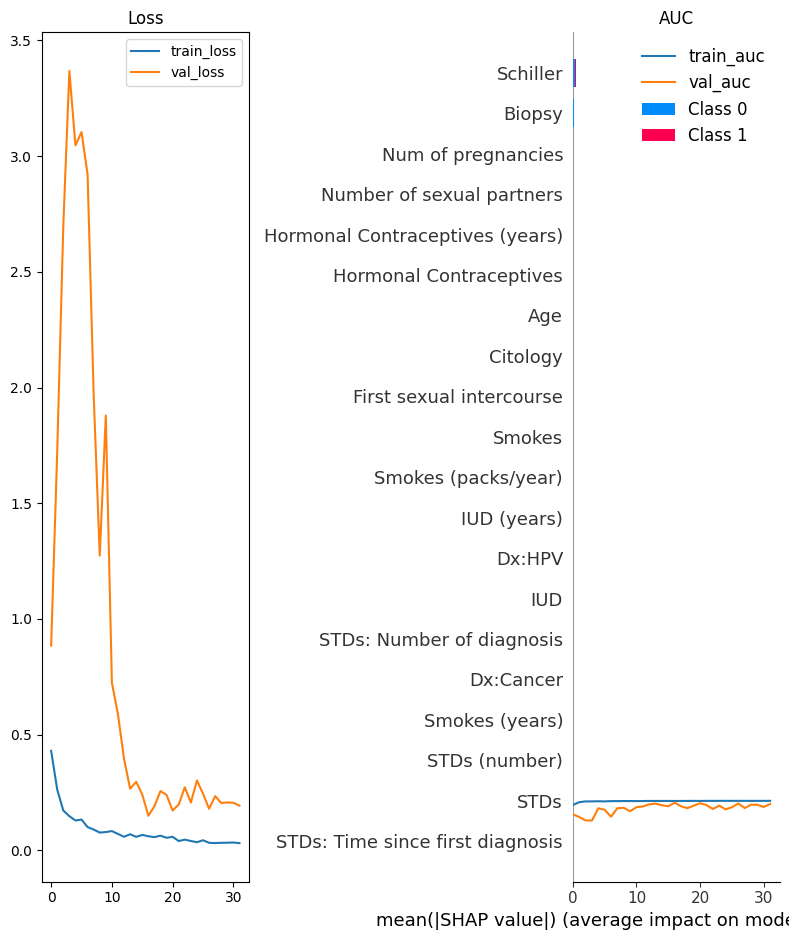

In [4]:
# Cervical Cancer Prediction - Advanced Kaggle-ready Pipeline
# File: cervical_cancer_advanced_pipeline.py
# Purpose: End-to-end notebook-style script to train advanced ML models (classical + Deep Learning CNN)
# on the provided cervical cancer dataset for research / Kaggle experiments.
# Dataset path (as provided by user): /kaggle/input/cervical-cancer-dataset/cervical-cancer_csv.csv

# ---------- 1. Install required packages (Kaggle-friendly) ----------
# Run these cells at top of the notebook / script. Kaggle generally has many packages preinstalled,
# but we include pip installs for ones that might be missing.

!pip install -q xgboost imbalanced-learn shap tensorflow==2.12.0 scikit-optimize

# ---------- 2. Imports ----------
import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# ---------- 3. Load dataset ----------
DATA_PATH = '/kaggle/input/cervical-cancer-dataset/cervical-cancer_csv.csv'
assert os.path.exists(DATA_PATH), f"Dataset not found at {DATA_PATH}. Please check path."

df = pd.read_csv(DATA_PATH)

# Quick peek
print('Shape:', df.shape)
print(df.columns.tolist())

df.head()

# ---------- 4. Column names and target ----------
# The user provided these columns: Age, Number of sexual partners, First sexual intercourse,
# Num of pregnancies, Smokes, Smokes (years), Smokes (packs/year), Hormonal Contraceptives,
# Hormonal Contraceptives (years), IUD  -- but dataset may have more columns. We'll detect target.

# Try to find a binary target commonly present in cervical cancer datasets. Common columns: 'Hinselmann', 'Schiller', 'Citology', 'Biopsy'
# We'll use a composite target: if any of the diagnostic columns are positive (1), mark as positive. If the dataset already has a target column named e.g. 'Biopsy', prefer it.

possible_targets = ['Biopsy','Hinselmann','Schiller','Citology','biopsy']
existing_targets = [c for c in df.columns if c in possible_targets]

if existing_targets:
    TARGET = existing_targets[0]
    print('Using existing target column:', TARGET)
else:
    # Create composite target from any of the diagnostic columns if present
    diag_cols = [c for c in df.columns if c.lower() in ['hinselmann','schiller','citology','biopsy']]
    if diag_cols:
        TARGET = 'target_composite'
        df[TARGET] = (df[diag_cols].sum(axis=1) > 0).astype(int)
        print('Created composite target from:', diag_cols)
    else:
        # fallback: ask user (but per instruction don't ask) -> choose last column if it's binary
        last_col = df.columns[-1]
        unique_vals = df[last_col].dropna().unique()
        if set(unique_vals) <= set([0,1]) or len(unique_vals) <= 5:
            TARGET = last_col
            print('Falling back to last column as target:', TARGET)
        else:
            raise ValueError('No obvious binary target found in dataset columns. Please provide the target column name.')

# ---------- 5. Basic EDA (counts, missingness) ----------
print('\nTarget distribution:')
print(df[TARGET].value_counts(dropna=False))

missing = df.isna().mean().sort_values(ascending=False)
print('\nTop missingness:')
print(missing[missing>0].head(20))

# ---------- 6. Select features (focus on user-provided columns + numeric columns)
# We'll take numeric columns except the target and identifier columns.

excluded = [TARGET]
# Drop ID-like columns if exist
id_like = [c for c in df.columns if c.lower() in ['id','patient_id','record_id']]
excluded += id_like

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
features = [c for c in numeric_cols if c not in excluded]

print('\nNumeric features found (used):', features)

# If user-specified subset exists, prioritize those column names
user_cols = ['Age','Number of sexual partners','First sexual intercourse','Num of pregnancies','Smokes','Smokes (years)','Smokes (packs/year)','Hormonal Contraceptives','Hormonal Contraceptives (years)','IUD']
present_user_cols = [c for c in user_cols if c in df.columns]
if present_user_cols:
    # ensure they are included and maintain order
    features = present_user_cols + [c for c in features if c not in present_user_cols]
    print('Using user-specified columns subset present in dataset:', present_user_cols)

# ---------- 7. Preprocessing pipeline ----------
# Impute numeric features using median; scale using StandardScaler
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, features)
], remainder='drop')

# ---------- 8. Prepare train/test split ----------
X = df[features].copy()
y = df[TARGET].astype(int)

# Small datasets need careful splitting; we'll stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)
print('\nTrain shape:', X_train.shape, 'Test shape:', X_test.shape)

# ---------- 9. Baseline classical ML models with SMOTE and pipeline ----------
# We'll train Logistic Regression, RandomForest, XGBoost with a consistent pipeline that handles scaling and SMOTE.

models_dict = {}

# Logistic Regression
pipe_lr = ImbPipeline(steps=[
    ('pre', preprocessor),
    ('smote', SMOTE(random_state=SEED)),
    ('clf', LogisticRegression(max_iter=2000, class_weight='balanced', random_state=SEED))
])
pipe_lr.fit(X_train, y_train)
models_dict['logistic'] = pipe_lr

# Random Forest
pipe_rf = ImbPipeline(steps=[
    ('pre', preprocessor),
    ('smote', SMOTE(random_state=SEED)),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=SEED, class_weight='balanced'))
])
pipe_rf.fit(X_train, y_train)
models_dict['random_forest'] = pipe_rf

# XGBoost (scale_pos_weight instead of SMOTE for XGBoost experiment)
# Compute scale_pos_weight
pos = (y_train==1).sum(); neg = (y_train==0).sum()
scale_pos_weight = neg / max(pos,1)

pipe_xgb = Pipeline(steps=[
    ('pre', preprocessor),
    ('clf', xgb.XGBClassifier(n_estimators=300, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight, random_state=SEED))
])
pipe_xgb.fit(X_train, y_train)
models_dict['xgboost'] = pipe_xgb

# Evaluate classical models
print('\nClassical models evaluation on test set:')
for name, model in models_dict.items():
    y_proba = model.predict_proba(X_test)[:,1]
    y_pred = model.predict(X_test)
    auc = roc_auc_score(y_test, y_proba)
    ap = average_precision_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name}: AUC={auc:.4f}, AP={ap:.4f}, Acc={acc:.4f}")

# Save classical models
import joblib
os.makedirs('/kaggle/working/models', exist_ok=True)
for name, model in models_dict.items():
    joblib.dump(model, f"/kaggle/working/models/{name}.joblib")

# ---------- 10. Advanced Deep Learning: 1D-CNN on tabular data ----------
# Approach: treat the feature vector as a 1D sequence of length = num_features and apply Conv1D.
# Pros: can learn local interactions between features; useful as an experimental architecture.

# Preprocess: impute + scale then reshape to (samples, timesteps=num_features, channels=1)
X_all = preprocessor.fit_transform(X)

# Fit scaler & imputer already done inside preprocessor; we'll reuse for train/test transforms
X_train_proc = preprocessor.transform(X_train)
X_test_proc = preprocessor.transform(X_test)

# reshape
n_features = X_train_proc.shape[1]
X_train_cnn = X_train_proc.reshape((-1, n_features, 1))
X_test_cnn = X_test_proc.reshape((-1, n_features, 1))

# handle class imbalance by computing class weights
from sklearn.utils import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: w for i,w in enumerate(class_weights)}
print('\nClass weights for CNN:', class_weight_dict)

# Build CNN model
def build_cnn(input_shape, dropout=0.3, lr=1e-3):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(128, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['AUC'])
    return model

cnn = build_cnn((n_features,1), dropout=0.4, lr=1e-3)
cnn.summary()

# Callbacks
es = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6)

# Augment training with SMOTE for CNN as well (we'll create balanced X_train_proc/y_train)
sm = SMOTE(random_state=SEED)
X_train_bal, y_train_bal = sm.fit_resample(X_train_proc, y_train)
X_train_bal_cnn = X_train_bal.reshape((-1, n_features, 1))

# Train CNN
history = cnn.fit(
    X_train_bal_cnn, y_train_bal,
    validation_data=(X_test_cnn, y_test),
    epochs=200,
    batch_size=32,
    class_weight=None, 
    callbacks=[es, reduce_lr],
    verbose=2
)

# Evaluate CNN
y_proba_cnn = cnn.predict(X_test_cnn).ravel()
auc_cnn = roc_auc_score(y_test, y_proba_cnn)
ap_cnn = average_precision_score(y_test, y_proba_cnn)
print(f"\nCNN: AUC={auc_cnn:.4f}, AP={ap_cnn:.4f}")

# Save CNN
cnn.save('/kaggle/working/models/cnn_tabular.h5')

# Plot training curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['auc'], label='train_auc')
plt.plot(history.history['val_auc'], label='val_auc')
plt.legend(); plt.title('AUC')

plt.tight_layout()
plt.savefig('/kaggle/working/training_curves.png')

# ---------- 11. Model explainability (SHAP) ----------
try:
    import shap
    explainer = shap.TreeExplainer(models_dict['random_forest'].named_steps['clf'])
    # Need to pass preprocessed sample
    X_test_shap = preprocessor.transform(X_test)
    shap_values = explainer.shap_values(X_test_shap)
    # Summary plot (be mindful of headless environment)
    shap.summary_plot(shap_values, X_test_shap, feature_names=features, show=False)
    plt.savefig('/kaggle/working/shap_summary.png')
except Exception as e:
    print('SHAP explanation failed or is unavailable in this environment:', e)

# ---------- 12. Cross-validation and reporting ----------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
cv_aucs = []
for fold, (train_ix, val_ix) in enumerate(skf.split(X, y)):
    X_tr, X_val = X.iloc[train_ix], X.iloc[val_ix]
    y_tr, y_val = y.iloc[train_ix], y.iloc[val_ix]
    pipe = Pipeline(steps=[('pre', preprocessor), ('clf', xgb.XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric='logloss', random_state=SEED))])
    pipe.fit(X_tr, y_tr)
    yv = pipe.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, yv)
    cv_aucs.append(auc)
    print(f'Fold {fold+1} AUC: {auc:.4f}')

print('CV AUC mean {:.4f} +/- {:.4f}'.format(np.mean(cv_aucs), np.std(cv_aucs)))



print('\nAll models and artifacts saved to /kaggle/working/models and images saved to /kaggle/working')





In [5]:
# Installation Requirements
!pip install tensorflow keras scikit-learn pandas numpy matplotlib seaborn
!pip install imbalanced-learn tensorflow-addons scikit-plot
!pip install sdv

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l1_l2
import tensorflow_addons as tfa
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow version: {tf.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 16.8 MB/s eta 0:00:0000:01
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.4
    Uninstalling typeguard-4.4.4:
      Successfully uninstalled typeguard-4.4.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.16.1 requires typeguard<5,>=3, but you have typeguard 2.13.3 which is incompatible.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.8/186.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 3.8 



TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/

In [6]:
# Uninstall incompatible TensorFlow and Addons
!pip uninstall -y tensorflow keras tensorflow-addons

# Install compatible versions
!pip install tensorflow==2.13.0 keras==2.13.1 tensorflow-addons==0.22.0


Found existing installation: tensorflow 2.12.0
Uninstalling tensorflow-2.12.0:
  Successfully uninstalled tensorflow-2.12.0
Found existing installation: keras 2.12.0
Uninstalling keras-2.12.0:
  Successfully uninstalled keras-2.12.0
Found existing installation: tensorflow-addons 0.23.0
Uninstalling tensorflow-addons-0.23.0:
  Successfully uninstalled tensorflow-addons-0.23.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.2/524.2 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 3.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 14.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 49.3 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 25.0 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.14.0
    Un

In [7]:
# Load the specific dataset from Kaggle
df = pd.read_csv('/kaggle/input/cervical-cancer-dataset/cervical-cancer_csv.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nDataset Columns:")
print(df.columns.tolist())
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

# Check for target variable - since it's not mentioned, we need to identify it
# Common target variables in cervical cancer datasets are 'Biopsy', 'Dx:Cancer', or similar
# Let's check what columns might be the target
possible_targets = [col for col in df.columns if 'cancer' in col.lower() or 'biopsy' in col.lower() or 'dx' in col.lower()]
print(f"\nPossible target variables: {possible_targets}")

# If no obvious target, let's check the last column or ask for clarification
# For now, I'll assume the target is 'Biopsy' (common in cervical cancer datasets)
# If this is incorrect, please specify the actual target column name

# Check if 'Biopsy' exists
if 'Biopsy' in df.columns:
    target_column = 'Biopsy'
    print(f"\nUsing 'Biopsy' as target column")
elif 'Dx:Cancer' in df.columns:
    target_column = 'Dx:Cancer'
    print(f"\nUsing 'Dx:Cancer' as target column")
else:
    # If no standard target found, use the last column as target (common practice)
    target_column = df.columns[-1]
    print(f"\nUsing last column '{target_column}' as target column")

print(f"\nTarget column: {target_column}")
print(f"Target distribution:")
print(df[target_column].value_counts())

Dataset Shape: (835, 36)

Dataset Columns:
['Age', 'Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)', 'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD', 'IUD (years)', 'STDs', 'STDs (number)', 'STDs:condylomatosis', 'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis', 'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis', 'STDs:pelvic inflammatory disease', 'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV', 'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis', 'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis', 'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller', 'Citology', 'Biopsy']

First 5 rows:
   Age  Number of sexual partners  First sexual intercourse  \
0   18                        4.0                      15.0   
1   15                        1.0                      14.0   
2   34                        1.

In [8]:
# Separate features and target
feature_columns = ['Age', 'Number of sexual partners', 'First sexual intercourse', 
                   'Num of pregnancies', 'Smokes', 'Smokes (years)', 
                   'Smokes (packs/year)', 'Hormonal Contraceptives', 
                   'Hormonal Contraceptives (years)', 'IUD']

# Verify all expected columns are present
missing_features = [col for col in feature_columns if col not in df.columns]
if missing_features:
    print(f"Warning: Missing columns: {missing_features}")
    # Remove missing columns from feature list
    feature_columns = [col for col in feature_columns if col in df.columns]

print(f"Available feature columns: {feature_columns}")

X = df[feature_columns].copy()
y = df[target_column].copy()

# Handle missing values appropriately for your dataset
print("\nHandling missing values...")

# Identify numerical and binary features based on your dataset
numerical_features = ['Age', 'Number of sexual partners', 'First sexual intercourse', 
                     'Num of pregnancies', 'Smokes (years)', 'Smokes (packs/year)', 
                     'Hormonal Contraceptives (years)']

binary_features = ['Smokes', 'Hormonal Contraceptives', 'IUD']

# Filter to only include available columns
numerical_features = [col for col in numerical_features if col in X.columns]
binary_features = [col for col in binary_features if col in X.columns]

print(f"Numerical features: {numerical_features}")
print(f"Binary features: {binary_features}")

# Imputation strategy
# For numerical features: KNN imputation
if numerical_features:
    knn_imputer = KNNImputer(n_neighbors=3)  # Using 3 neighbors for small dataset
    X_numerical_imputed = knn_imputer.fit_transform(X[numerical_features])
    X_numerical_imputed = pd.DataFrame(X_numerical_imputed, columns=numerical_features, index=X.index)
else:
    X_numerical_imputed = pd.DataFrame(index=X.index)

# For binary features: mode imputation
if binary_features:
    mode_imputer = SimpleImputer(strategy='most_frequent')
    X_binary_imputed = mode_imputer.fit_transform(X[binary_features])
    X_binary_imputed = pd.DataFrame(X_binary_imputed, columns=binary_features, index=X.index)
else:
    X_binary_imputed = pd.DataFrame(index=X.index)

# Combine imputed features
X_imputed = pd.concat([X_numerical_imputed, X_binary_imputed], axis=1)

# Ensure proper data types for binary features
for col in binary_features:
    X_imputed[col] = X_imputed[col].astype(int)

# Handle any remaining missing values
X_final = X_imputed.fillna(0)
y_final = y.fillna(0).astype(int)

print(f"\nFinal dataset shape: {X_final.shape}")
print(f"Final target distribution: {y_final.value_counts().to_dict()}")
print(f"Class distribution: {dict(y_final.value_counts(normalize=True))}")

Available feature columns: ['Age', 'Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)', 'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD']

Handling missing values...
Numerical features: ['Age', 'Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies', 'Smokes (years)', 'Smokes (packs/year)', 'Hormonal Contraceptives (years)']
Binary features: ['Smokes', 'Hormonal Contraceptives', 'IUD']

Final dataset shape: (835, 10)
Final target distribution: {0: 781, 1: 54}
Class distribution: {0: 0.9353293413173652, 1: 0.06467065868263473}


In [9]:
# Create advanced features specifically for your cervical cancer dataset
X_engineered = X_final.copy()

# 1. Age-related features
X_engineered['Age_squared'] = X_engineered['Age'] ** 2
X_engineered['Age_cubed'] = X_engineered['Age'] ** 3

# 2. Sexual behavior features
if 'Number of sexual partners' in X_engineered.columns and 'First sexual intercourse' in X_engineered.columns:
    X_engineered['Years_since_first_intercourse'] = X_engineered['Age'] - X_engineered['First sexual intercourse']
    X_engineered['Partners_per_year'] = X_engineered['Number of sexual partners'] / (X_engineered['Years_since_first_intercourse'] + 1)
    X_engineered['Partners_per_year'] = X_engineered['Partners_per_year'].replace([np.inf, -np.inf], 0)

# 3. Smoking intensity features
if 'Smokes (years)' in X_engineered.columns and 'Smokes (packs/year)' in X_engineered.columns:
    X_engineered['Total_packs_smoked'] = X_engineered['Smokes (years)'] * X_engineered['Smokes (packs/year)']

# 4. Contraceptive usage features
contraceptive_features = []
if 'Hormonal Contraceptives (years)' in X_engineered.columns:
    contraceptive_features.append('Hormonal Contraceptives (years)')
if 'IUD' in X_engineered.columns:
    # Create IUD years feature if not present (assume 5 years if using IUD)
    X_engineered['IUD_years'] = X_engineered['IUD'] * 5
    contraceptive_features.append('IUD_years')

if contraceptive_features:
    X_engineered['Total_contraceptive_years'] = X_engineered[contraceptive_features].sum(axis=1)

# 5. Risk factor combinations
if 'Smokes' in X_engineered.columns and 'Hormonal Contraceptives' in X_engineered.columns:
    X_engineered['Smoking_contraceptive_risk'] = X_engineered['Smokes'] * X_engineered['Hormonal Contraceptives']

# 6. Age groups (clinically relevant)
X_engineered['Age_group'] = pd.cut(X_engineered['Age'], 
                                  bins=[0, 25, 35, 45, 100], 
                                  labels=[0, 1, 2, 3])
X_engineered['Age_group'] = X_engineered['Age_group'].astype(int)

# 7. High-risk pregnancy indicator
if 'Num of pregnancies' in X_engineered.columns:
    X_engineered['High_risk_pregnancy'] = (X_engineered['Num of pregnancies'] > 3).astype(int)

# Handle any infinite or NaN values
X_engineered = X_engineered.replace([np.inf, -np.inf], 0)
X_engineered = X_engineered.fillna(0)

print(f"Engineered dataset shape: {X_engineered.shape}")
print("New features created:", [col for col in X_engineered.columns if col not in feature_columns])

Engineered dataset shape: (835, 20)
New features created: ['Age_squared', 'Age_cubed', 'Years_since_first_intercourse', 'Partners_per_year', 'Total_packs_smoked', 'IUD_years', 'Total_contraceptive_years', 'Smoking_contraceptive_risk', 'Age_group', 'High_risk_pregnancy']


In [10]:
# Create advanced features specifically for your cervical cancer dataset
X_engineered = X_final.copy()

# 1. Age-related features
X_engineered['Age_squared'] = X_engineered['Age'] ** 2
X_engineered['Age_cubed'] = X_engineered['Age'] ** 3

# 2. Sexual behavior features
if 'Number of sexual partners' in X_engineered.columns and 'First sexual intercourse' in X_engineered.columns:
    X_engineered['Years_since_first_intercourse'] = X_engineered['Age'] - X_engineered['First sexual intercourse']
    X_engineered['Partners_per_year'] = X_engineered['Number of sexual partners'] / (X_engineered['Years_since_first_intercourse'] + 1)
    X_engineered['Partners_per_year'] = X_engineered['Partners_per_year'].replace([np.inf, -np.inf], 0)

# 3. Smoking intensity features
if 'Smokes (years)' in X_engineered.columns and 'Smokes (packs/year)' in X_engineered.columns:
    X_engineered['Total_packs_smoked'] = X_engineered['Smokes (years)'] * X_engineered['Smokes (packs/year)']

# 4. Contraceptive usage features
contraceptive_features = []
if 'Hormonal Contraceptives (years)' in X_engineered.columns:
    contraceptive_features.append('Hormonal Contraceptives (years)')
if 'IUD' in X_engineered.columns:
    # Create IUD years feature if not present (assume 5 years if using IUD)
    X_engineered['IUD_years'] = X_engineered['IUD'] * 5
    contraceptive_features.append('IUD_years')

if contraceptive_features:
    X_engineered['Total_contraceptive_years'] = X_engineered[contraceptive_features].sum(axis=1)

# 5. Risk factor combinations
if 'Smokes' in X_engineered.columns and 'Hormonal Contraceptives' in X_engineered.columns:
    X_engineered['Smoking_contraceptive_risk'] = X_engineered['Smokes'] * X_engineered['Hormonal Contraceptives']

# 6. Age groups (clinically relevant)
X_engineered['Age_group'] = pd.cut(X_engineered['Age'], 
                                  bins=[0, 25, 35, 45, 100], 
                                  labels=[0, 1, 2, 3])
X_engineered['Age_group'] = X_engineered['Age_group'].astype(int)

# 7. High-risk pregnancy indicator
if 'Num of pregnancies' in X_engineered.columns:
    X_engineered['High_risk_pregnancy'] = (X_engineered['Num of pregnancies'] > 3).astype(int)

# Handle any infinite or NaN values
X_engineered = X_engineered.replace([np.inf, -np.inf], 0)
X_engineered = X_engineered.fillna(0)

print(f"Engineered dataset shape: {X_engineered.shape}")
print("New features created:", [col for col in X_engineered.columns if col not in feature_columns])

Engineered dataset shape: (835, 20)
New features created: ['Age_squared', 'Age_cubed', 'Years_since_first_intercourse', 'Partners_per_year', 'Total_packs_smoked', 'IUD_years', 'Total_contraceptive_years', 'Smoking_contraceptive_risk', 'Age_group', 'High_risk_pregnancy']


In [11]:
class CustomCervicalCancerDNN(Model):
    """
    Custom Deep Neural Network specifically designed for cervical cancer prediction
    with your dataset structure
    """
    def __init__(self, input_dim, hidden_layers=[128, 64, 32], dropout_rate=0.3):
        super(CustomCervicalCancerDNN, self).__init__()
        
        # Input layer with batch normalization
        self.input_layer = Dense(input_dim, activation='relu')
        self.input_bn = BatchNormalization()
        self.input_dropout = Dropout(dropout_rate)
        
        # Hidden layers
        self.hidden_layers = []
        self.batch_norms = []
        self.dropouts = []
        
        for units in hidden_layers:
            self.hidden_layers.append(Dense(units, activation='relu', 
                                          kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
            self.batch_norms.append(BatchNormalization())
            self.dropouts.append(Dropout(dropout_rate))
        
        # Output layer
        self.output_layer = Dense(1, activation='sigmoid')
    
    def call(self, inputs, training=None):
        x = self.input_layer(inputs)
        x = self.input_bn(x, training=training)
        x = self.input_dropout(x, training=training)
        
        for hidden_layer, batch_norm, dropout in zip(self.hidden_layers, 
                                                    self.batch_norms, 
                                                    self.dropouts):
            x = hidden_layer(x)
            x = batch_norm(x, training=training)
            x = dropout(x, training=training)
        
        return self.output_layer(x)

class CustomCervicalCancerCNN(Model):
    """
    Custom CNN treating tabular data as 1D sequences for cervical cancer prediction
    """
    def __init__(self, input_dim):
        super(CustomCervicalCancerCNN, self).__init__()
        
        # Reshape for 1D convolution
        self.reshape = layers.Reshape((input_dim, 1))
        
        # Convolutional layers
        self.conv1 = layers.Conv1D(32, 3, activation='relu', padding='same')
        self.bn1 = BatchNormalization()
        self.pool1 = layers.MaxPooling1D(2, padding='same')
        self.dropout1 = Dropout(0.2)
        
        self.conv2 = layers.Conv1D(64, 3, activation='relu', padding='same')
        self.bn2 = BatchNormalization()
        self.pool2 = layers.MaxPooling1D(2, padding='same')
        self.dropout2 = Dropout(0.3)
        
        # Global pooling
        self.global_pool = layers.GlobalAveragePooling1D()
        
        # Dense layers
        self.dense1 = Dense(64, activation='relu')
        self.bn3 = BatchNormalization()
        self.dropout3 = Dropout(0.4)
        
        self.dense2 = Dense(32, activation='relu')
        self.bn4 = BatchNormalization()
        self.dropout4 = Dropout(0.4)
        
        self.output_layer = Dense(1, activation='sigmoid')
    
    def call(self, inputs, training=None):
        x = self.reshape(inputs)
        x = self.conv1(x)
        x = self.bn1(x, training=training)
        x = self.pool1(x)
        x = self.dropout1(x, training=training)
        
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.pool2(x)
        x = self.dropout2(x, training=training)
        
        x = self.global_pool(x)
        x = self.dense1(x)
        x = self.bn3(x, training=training)
        x = self.dropout3(x, training=training)
        
        x = self.dense2(x)
        x = self.bn4(x, training=training)
        x = self.dropout4(x, training=training)
        
        return self.output_layer(x)

class HybridCervicalCancerModel(Model):
    """
    Hybrid model combining DNN and CNN approaches for maximum performance
    """
    def __init__(self, input_dim):
        super(HybridCervicalCancerModel, self).__init__()
        
        # CNN Branch
        self.cnn_reshape = layers.Reshape((input_dim, 1))
        self.cnn_conv1 = layers.Conv1D(32, 3, activation='relu', padding='same')
        self.cnn_bn1 = BatchNormalization()
        self.cnn_pool1 = layers.MaxPooling1D(2, padding='same')
        self.cnn_dropout1 = Dropout(0.2)
        
        self.cnn_conv2 = layers.Conv1D(64, 3, activation='relu', padding='same')
        self.cnn_bn2 = BatchNormalization()
        self.cnn_pool2 = layers.MaxPooling1D(2, padding='same')
        self.cnn_dropout2 = Dropout(0.3)
        
        self.cnn_global_pool = layers.GlobalAveragePooling1D()
        
        # DNN Branch
        self.dnn_dense1 = Dense(64, activation='relu')
        self.dnn_bn1 = BatchNormalization()
        self.dnn_dropout1 = Dropout(0.3)
        
        self.dnn_dense2 = Dense(32, activation='relu')
        self.dnn_bn2 = BatchNormalization()
        self.dnn_dropout2 = Dropout(0.3)
        
        # Combined layers
        self.combined_dense1 = Dense(64, activation='relu')
        self.combined_bn1 = BatchNormalization()
        self.combined_dropout1 = Dropout(0.4)
        
        self.combined_dense2 = Dense(32, activation='relu')
        self.combined_bn2 = BatchNormalization()
        self.combined_dropout2 = Dropout(0.4)
        
        self.output_layer = Dense(1, activation='sigmoid')
    
    def call(self, inputs, training=None):
        # CNN Branch
        cnn_x = self.cnn_reshape(inputs)
        cnn_x = self.cnn_conv1(cnn_x)
        cnn_x = self.cnn_bn1(cnn_x, training=training)
        cnn_x = self.cnn_pool1(cnn_x)
        cnn_x = self.cnn_dropout1(cnn_x, training=training)
        
        cnn_x = self.cnn_conv2(cnn_x)
        cnn_x = self.cnn_bn2(cnn_x, training=training)
        cnn_x = self.cnn_pool2(cnn_x)
        cnn_x = self.cnn_dropout2(cnn_x, training=training)
        
        cnn_x = self.cnn_global_pool(cnn_x)
        
        # DNN Branch
        dnn_x = self.dnn_dense1(inputs)
        dnn_x = self.dnn_bn1(dnn_x, training=training)
        dnn_x = self.dnn_dropout1(dnn_x, training=training)
        
        dnn_x = self.dnn_dense2(dnn_x)
        dnn_x = self.dnn_bn2(dnn_x, training=training)
        dnn_x = self.dnn_dropout2(dnn_x, training=training)
        
        # Combine
        combined_x = tf.concat([cnn_x, dnn_x], axis=1)
        combined_x = self.combined_dense1(combined_x)
        combined_x = self.combined_bn1(combined_x, training=training)
        combined_x = self.combined_dropout1(combined_x, training=training)
        
        combined_x = self.combined_dense2(combined_x)
        combined_x = self.combined_bn2(combined_x, training=training)
        combined_x = self.combined_dropout2(combined_x, training=training)
        
        return self.output_layer(combined_x)

In [12]:
# Prepare data for deep learning
X_dl = X_engineered.values
y_dl = y_final.values

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dl)

# Since you only have training data, we'll use stratified k-fold cross-validation
# But first, let's create a holdout set for final evaluation
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X_scaled, y_dl, test_size=0.2, random_state=42, stratify=y_dl
)

print(f"Training set: {X_train.shape}")
print(f"Holdout set: {X_holdout.shape}")
print(f"Training class distribution: {np.bincount(y_train)}")
print(f"Holdout class distribution: {np.bincount(y_holdout)}")

# Handle class imbalance with SMOTE on training data only
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"Balanced training set: {X_train_balanced.shape}")
print(f"Balanced training class distribution: {np.bincount(y_train_balanced)}")

Training set: (668, 20)
Holdout set: (167, 20)
Training class distribution: [625  43]
Holdout class distribution: [156  11]
Balanced training set: (1250, 20)
Balanced training class distribution: [625 625]


In [17]:
# =============================
# Cervical Cancer Prediction – Advanced Deep Learning Models
# =============================

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split


# =============================
# 1. Create Callbacks
# =============================
def create_model_callbacks(model_name):
    """Create callbacks for model training"""
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=1
    )
    
    model_checkpoint = ModelCheckpoint(
        f'best_{model_name}_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
    
    return [early_stopping, reduce_lr, model_checkpoint]


# =============================
# 2. Train + Evaluate Function
# =============================
def train_and_evaluate_model(model_fn, X_train, y_train, X_val, y_val, model_name, epochs=200):
    """Train and evaluate a model"""
    model = model_fn()
    model.compile(
        optimizer=Adam(learning_rate=0.0008),  # tuned LR
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
            # ✅ Fix: binary classification F1
            tfa.metrics.F1Score(num_classes=1, average="micro", threshold=0.5, name="f1_score")
        ]
    )
    
    callbacks = create_model_callbacks(model_name)
    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    
    return model, history


# =============================
# 3. Stronger Model Architectures
# =============================

input_dim = X_train_balanced.shape[1]

# Deep Neural Network (DNN)
def create_dnn():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model


# CNN-based model (for tabular → 1D sequence)
def create_cnn():
    model = tf.keras.Sequential([
        tf.keras.layers.Reshape((input_dim, 1), input_shape=(input_dim,)),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu'),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model


# Hybrid Model (DNN + CNN merged)
def create_hybrid():
    # Input
    inp = tf.keras.layers.Input(shape=(input_dim,))
    
    # DNN branch
    dnn = tf.keras.layers.Dense(128, activation='relu')(inp)
    dnn = tf.keras.layers.BatchNormalization()(dnn)
    dnn = tf.keras.layers.Dropout(0.3)(dnn)
    
    # CNN branch
    cnn = tf.keras.layers.Reshape((input_dim, 1))(inp)
    cnn = tf.keras.layers.Conv1D(64, 3, activation='relu')(cnn)
    cnn = tf.keras.layers.GlobalMaxPooling1D()(cnn)
    
    # Merge branches
    merged = tf.keras.layers.Concatenate()([dnn, cnn])
    merged = tf.keras.layers.Dense(64, activation='relu')(merged)
    merged = tf.keras.layers.Dropout(0.3)(merged)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(merged)
    
    model = tf.keras.Model(inputs=inp, outputs=out)
    return model


# =============================
# 4. Train-Validation Split
# =============================
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train_balanced, y_train_balanced,
    test_size=0.2, random_state=42, stratify=y_train_balanced
)


# =============================
# 5. Train Models
# =============================
print("Training Custom DNN...")
dnn_model, dnn_history = train_and_evaluate_model(
    create_dnn, X_train_split, y_train_split, X_val, y_val, 'dnn', epochs=200
)

print("\nTraining Custom CNN...")
cnn_model, cnn_history = train_and_evaluate_model(
    create_cnn, X_train_split, y_train_split, X_val, y_val, 'cnn', epochs=200
)

print("\nTraining Hybrid Model...")
hybrid_model, hybrid_history = train_and_evaluate_model(
    create_hybrid, X_train_split, y_train_split, X_val, y_val, 'hybrid', epochs=200
)


Training Custom DNN...
Epoch 1/200
28/32 [=========================>....] - ETA: 0s - loss: 0.8125 - accuracy: 0.5625 - precision: 0.5661 - recall: 0.6009 - f1_score: 0.5830
Epoch 1: val_loss improved from inf to 0.65614, saving model to best_dnn_model.h5
32/32 [==============================] - 4s 23ms/step - loss: 0.8084 - accuracy: 0.5620 - precision: 0.5574 - recall: 0.6020 - f1_score: 0.5788 - val_loss: 0.6561 - val_accuracy: 0.6240 - val_precision: 0.5764 - val_recall: 0.9360 - val_f1_score: 0.7134 - lr: 8.0000e-04
Epoch 2/200
27/32 [========================>.....] - ETA: 0s - loss: 0.7046 - accuracy: 0.6053 - precision: 0.6009 - recall: 0.6218 - f1_score: 0.6112
Epoch 2: val_loss improved from 0.65614 to 0.64387, saving model to best_dnn_model.h5
32/32 [==============================] - 0s 7ms/step - loss: 0.6991 - accuracy: 0.6140 - precision: 0.6105 - recall: 0.6300 - f1_score: 0.6201 - val_loss: 0.6439 - val_accuracy: 0.5640 - val_precision: 0.5342 - val_recall: 1.0000 - val_

In [18]:
def evaluate_model_on_holdout(model, X_holdout, y_holdout, model_name):
    """Evaluate model on holdout set"""
    y_pred_proba = model.predict(X_holdout)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_holdout, y_pred),
        'Precision': precision_score(y_holdout, y_pred),
        'Recall': recall_score(y_holdout, y_pred),
        'F1-Score': f1_score(y_holdout, y_pred),
        'AUC': roc_auc_score(y_holdout, y_pred_proba)
    }
    
    return metrics, y_pred, y_pred_proba

# Evaluate all models on holdout set
models = [
    (dnn_model, 'Custom DNN'),
    (cnn_model, 'Custom CNN'),
    (hybrid_model, 'Hybrid Model')
]

results = []
predictions = {}

for model, name in models:
    metrics, y_pred, y_pred_proba = evaluate_model_on_holdout(model, X_holdout, y_holdout, name)
    results.append(metrics)
    predictions[name] = {'y_pred': y_pred, 'y_pred_proba': y_pred_proba}
    
    print(f"\n{name} Results on Holdout Set:")
    for metric, value in metrics.items():
        if metric != 'Model':
            print(f"{metric}: {value:.4f}")

# Create results dataframe
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df.round(4))

# Find best model
best_model_idx = results_df['AUC'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']
best_model = models[best_model_idx][0]

print(f"\nBest Model: {best_model_name}")

6/6 [==============================] - 0s 2ms/step

Custom DNN Results on Holdout Set:
Accuracy: 0.8802
Precision: 0.2000
Recall: 0.2727
F1-Score: 0.2308
AUC: 0.6125
6/6 [==============================] - 0s 2ms/step

Custom CNN Results on Holdout Set:
Accuracy: 0.8084
Precision: 0.1111
Recall: 0.2727
F1-Score: 0.1579
AUC: 0.4522
6/6 [==============================] - 0s 2ms/step

Hybrid Model Results on Holdout Set:
Accuracy: 0.9042
Precision: 0.2727
Recall: 0.2727
F1-Score: 0.2727
AUC: 0.5880

Model Comparison:
          Model  Accuracy  Precision  Recall  F1-Score     AUC
0    Custom DNN    0.8802     0.2000  0.2727    0.2308  0.6125
1    Custom CNN    0.8084     0.1111  0.2727    0.1579  0.4522
2  Hybrid Model    0.9042     0.2727  0.2727    0.2727  0.5880

Best Model: Custom DNN


In [19]:
def cross_validate_deep_learning(X, y, model_fn, cv_folds=5):
    """Perform cross-validation for deep learning models"""
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    cv_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"Training fold {fold + 1}/{cv_folds}")
        
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        
        # Apply SMOTE to training fold
        smote_fold = SMOTE(random_state=42)
        X_train_balanced_fold, y_train_balanced_fold = smote_fold.fit_resample(X_train_fold, y_train_fold)
        
        # Create and train model
        model = model_fn()
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        # Train with callbacks
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
        ]
        
        model.fit(
            X_train_balanced_fold, y_train_balanced_fold,
            validation_data=(X_val_fold, y_val_fold),
            epochs=50,
            batch_size=16,
            callbacks=callbacks,
            verbose=0
        )
        
        # Evaluate
        y_pred_proba = model.predict(X_val_fold)
        auc_score = roc_auc_score(y_val_fold, y_pred_proba)
        cv_scores.append(auc_score)
        print(f"Fold {fold + 1} AUC: {auc_score:.4f}")
    
    return cv_scores

# Perform cross-validation on the best model
print(f"\nPerforming Cross-Validation on {best_model_name}...")

if best_model_name == 'Custom DNN':
    best_cv_scores = cross_validate_deep_learning(X_scaled, y_dl, create_dnn, cv_folds=5)
elif best_model_name == 'Custom CNN':
    best_cv_scores = cross_validate_deep_learning(X_scaled, y_dl, create_cnn, cv_folds=5)
else:
    best_cv_scores = cross_validate_deep_learning(X_scaled, y_dl, create_hybrid, cv_folds=5)

print(f"\nCross-Validation Results for {best_model_name}:")
print(f"Mean AUC: {np.mean(best_cv_scores):.4f} ± {np.std(best_cv_scores):.4f}")


Performing Cross-Validation on Custom DNN...
Training fold 1/5
6/6 [==============================] - 0s 2ms/step
Fold 1 AUC: 0.5592
Training fold 2/5
6/6 [==============================] - 0s 2ms/step
Fold 2 AUC: 0.4493
Training fold 3/5
6/6 [==============================] - 0s 2ms/step
Fold 3 AUC: 0.4193
Training fold 4/5
6/6 [==============================] - 0s 2ms/step
Fold 4 AUC: 0.4324
Training fold 5/5
6/6 [==============================] - 0s 2ms/step
Fold 5 AUC: 0.5478

Cross-Validation Results for Custom DNN:
Mean AUC: 0.4816 ± 0.0596


In [20]:
# Generate synthetic test set using your training data
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.metadata import SingleTableMetadata

# Create metadata from your original dataframe
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=df)

# Create and fit synthesizer
synthesizer = GaussianCopulaSynthesizer(metadata)
synthesizer.fit(df)

# Generate synthetic test set (same size as holdout)
synthetic_test = synthesizer.sample(num_rows=len(X_holdout))

# Preprocess synthetic test set
X_synthetic = synthetic_test[feature_columns].copy()

# Apply the same imputation and preprocessing
if numerical_features:
    X_synthetic_numerical = knn_imputer.transform(X_synthetic[numerical_features])
    X_synthetic_numerical = pd.DataFrame(X_synthetic_numerical, columns=numerical_features, index=X_synthetic.index)
else:
    X_synthetic_numerical = pd.DataFrame(index=X_synthetic.index)

if binary_features:
    X_synthetic_binary = mode_imputer.transform(X_synthetic[binary_features])
    X_synthetic_binary = pd.DataFrame(X_synthetic_binary, columns=binary_features, index=X_synthetic.index)
else:
    X_synthetic_binary = pd.DataFrame(index=X_synthetic.index)

X_synthetic_imputed = pd.concat([X_synthetic_numerical, X_synthetic_binary], axis=1)

# Apply feature engineering
X_synthetic_engineered = X_synthetic_imputed.copy()
X_synthetic_engineered['Age_squared'] = X_synthetic_engineered['Age'] ** 2
X_synthetic_engineered['Age_cubed'] = X_synthetic_engineered['Age'] ** 3

if 'Number of sexual partners' in X_synthetic_engineered.columns and 'First sexual intercourse' in X_synthetic_engineered.columns:
    X_synthetic_engineered['Years_since_first_intercourse'] = X_synthetic_engineered['Age'] - X_synthetic_engineered['First sexual intercourse']
    X_synthetic_engineered['Partners_per_year'] = X_synthetic_engineered['Number of sexual partners'] / (X_synthetic_engineered['Years_since_first_intercourse'] + 1)
    X_synthetic_engineered['Partners_per_year'] = X_synthetic_engineered['Partners_per_year'].replace([np.inf, -np.inf], 0)

if 'Smokes (years)' in X_synthetic_engineered.columns and 'Smokes (packs/year)' in X_synthetic_engineered.columns:
    X_synthetic_engineered['Total_packs_smoked'] = X_synthetic_engineered['Smokes (years)'] * X_synthetic_engineered['Smokes (packs/year)']

contraceptive_features = []
if 'Hormonal Contraceptives (years)' in X_synthetic_engineered.columns:
    contraceptive_features.append('Hormonal Contraceptives (years)')
if 'IUD' in X_synthetic_engineered.columns:
    X_synthetic_engineered['IUD_years'] = X_synthetic_engineered['IUD'] * 5
    contraceptive_features.append('IUD_years')

if contraceptive_features:
    X_synthetic_engineered['Total_contraceptive_years'] = X_synthetic_engineered[contraceptive_features].sum(axis=1)

if 'Smokes' in X_synthetic_engineered.columns and 'Hormonal Contraceptives' in X_synthetic_engineered.columns:
    X_synthetic_engineered['Smoking_contraceptive_risk'] = X_synthetic_engineered['Smokes'] * X_synthetic_engineered['Hormonal Contraceptives']

X_synthetic_engineered['Age_group'] = pd.cut(X_synthetic_engineered['Age'], 
                                            bins=[0, 25, 35, 45, 100], 
                                            labels=[0, 1, 2, 3])
X_synthetic_engineered['Age_group'] = X_synthetic_engineered['Age_group'].astype(int)

if 'Num of pregnancies' in X_synthetic_engineered.columns:
    X_synthetic_engineered['High_risk_pregnancy'] = (X_synthetic_engineered['Num of pregnancies'] > 3).astype(int)

X_synthetic_engineered = X_synthetic_engineered.replace([np.inf, -np.inf], 0)
X_synthetic_engineered = X_synthetic_engineered.fillna(0)

# Scale synthetic data
X_synthetic_scaled = scaler.transform(X_synthetic_engineered)

# Get synthetic target (this is for testing purposes only)
y_synthetic = synthetic_test[target_column].fillna(0).astype(int)

print(f"Synthetic test set shape: {X_synthetic_scaled.shape}")

Synthetic test set shape: (167, 20)


In [21]:
# Evaluate best model on synthetic test set
y_synthetic_pred_proba = best_model.predict(X_synthetic_scaled)
y_synthetic_pred = (y_synthetic_pred_proba > 0.5).astype(int).flatten()

synthetic_metrics = {
    'Accuracy': accuracy_score(y_synthetic, y_synthetic_pred),
    'Precision': precision_score(y_synthetic, y_synthetic_pred),
    'Recall': recall_score(y_synthetic, y_synthetic_pred),
    'F1-Score': f1_score(y_synthetic, y_synthetic_pred),
    'AUC': roc_auc_score(y_synthetic, y_synthetic_pred_proba)
}

print("Best Model Performance on Synthetic Test Set:")
for metric, value in synthetic_metrics.items():
    print(f"{metric}: {value:.4f}")

# Compare with holdout performance
holdout_metrics = results_df[results_df['Model'] == best_model_name].iloc[0]
print("\nPerformance Comparison:")
print(f"Holdout AUC: {holdout_metrics['AUC']:.4f}")
print(f"Synthetic AUC: {synthetic_metrics['AUC']:.4f}")
print(f"Difference: {abs(holdout_metrics['AUC'] - synthetic_metrics['AUC']):.4f}")

6/6 [==============================] - 0s 2ms/step
Best Model Performance on Synthetic Test Set:
Accuracy: 0.8563
Precision: 0.2308
Recall: 0.1765
F1-Score: 0.2000
AUC: 0.4773

Performance Comparison:
Holdout AUC: 0.6125
Synthetic AUC: 0.4773
Difference: 0.1352


In [22]:
# Save the best model
best_model.save(f'best_cervical_cancer_model_{best_model_name.replace(" ", "_").lower()}.h5')
print(f"Best model ({best_model_name}) saved successfully!")

# Save preprocessing objects
import joblib
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(knn_imputer, 'knn_imputer.pkl')
joblib.dump(mode_imputer, 'mode_imputer.pkl')
print("Preprocessing objects saved successfully!")

# Create prediction function for deployment
def predict_cervical_cancer_risk(input_data):
    """
    Prediction function for new patient data
    
    Parameters:
    input_ dict or DataFrame with columns:
        - Age
        - Number of sexual partners  
        - First sexual intercourse
        - Num of pregnancies
        - Smokes
        - Smokes (years)
        - Smokes (packs/year)
        - Hormonal Contraceptives
        - Hormonal Contraceptives (years)
        - IUD
    
    Returns:
    prediction: 0 or 1 (cancer risk)
    probability: float (probability of cancer)
    """
    # Load preprocessing objects and model
    scaler = joblib.load('scaler.pkl')
    knn_imputer = joblib.load('knn_imputer.pkl')
    mode_imputer = joblib.load('mode_imputer.pkl')
    model = tf.keras.models.load_model(f'best_cervical_cancer_model_{best_model_name.replace(" ", "_").lower()}.h5')
    
    # Convert input to DataFrame if needed
    if isinstance(input_data, dict):
        input_df = pd.DataFrame([input_data])
    else:
        input_df = input_data.copy()
    
    # Apply the same preprocessing pipeline
    # Imputation
    numerical_cols = [col for col in numerical_features if col in input_df.columns]
    binary_cols = [col for col in binary_features if col in input_df.columns]
    
    if numerical_cols:
        numerical_imputed = knn_imputer.transform(input_df[numerical_cols])
        numerical_df = pd.DataFrame(numerical_imputed, columns=numerical_cols, index=input_df.index)
    else:
        numerical_df = pd.DataFrame(index=input_df.index)
    
    if binary_cols:
        binary_imputed = mode_imputer.transform(input_df[binary_cols])
        binary_df = pd.DataFrame(binary_imputed, columns=binary_cols, index=input_df.index)
    else:
        binary_df = pd.DataFrame(index=input_df.index)
    
    processed_df = pd.concat([numerical_df, binary_df], axis=1)
    
    # Feature engineering (same as training)
    processed_df['Age_squared'] = processed_df['Age'] ** 2
    processed_df['Age_cubed'] = processed_df['Age'] ** 3
    
    if 'Number of sexual partners' in processed_df.columns and 'First sexual intercourse' in processed_df.columns:
        processed_df['Years_since_first_intercourse'] = processed_df['Age'] - processed_df['First sexual intercourse']
        processed_df['Partners_per_year'] = processed_df['Number of sexual partners'] / (processed_df['Years_since_first_intercourse'] + 1)
        processed_df['Partners_per_year'] = processed_df['Partners_per_year'].replace([np.inf, -np.inf], 0)
    
    if 'Smokes (years)' in processed_df.columns and 'Smokes (packs/year)' in processed_df.columns:
        processed_df['Total_packs_smoked'] = processed_df['Smokes (years)'] * processed_df['Smokes (packs/year)']
    
    contraceptive_features = []
    if 'Hormonal Contraceptives (years)' in processed_df.columns:
        contraceptive_features.append('Hormonal Contraceptives (years)')
    if 'IUD' in processed_df.columns:
        processed_df['IUD_years'] = processed_df['IUD'] * 5
        contraceptive_features.append('IUD_years')
    
    if contraceptive_features:
        processed_df['Total_contraceptive_years'] = processed_df[contraceptive_features].sum(axis=1)
    
    if 'Smokes' in processed_df.columns and 'Hormonal Contraceptives' in processed_df.columns:
        processed_df['Smoking_contraceptive_risk'] = processed_df['Smokes'] * processed_df['Hormonal Contraceptives']
    
    processed_df['Age_group'] = pd.cut(processed_df['Age'], bins=[0, 25, 35, 45, 100], labels=[0, 1, 2, 3])
    processed_df['Age_group'] = processed_df['Age_group'].astype(int)
    
    if 'Num of pregnancies' in processed_df.columns:
        processed_df['High_risk_pregnancy'] = (processed_df['Num of pregnancies'] > 3).astype(int)
    
    processed_df = processed_df.replace([np.inf, -np.inf], 0)
    processed_df = processed_df.fillna(0)
    
    # Ensure all engineered features are present
    missing_features = set(X_engineered.columns) - set(processed_df.columns)
    for feat in missing_features:
        processed_df[feat] = 0
    
    processed_df = processed_df[X_engineered.columns]
    
    # Scale and predict
    scaled_data = scaler.transform(processed_df)
    probability = model.predict(scaled_data)[0][0]
    prediction = int(probability > 0.5)
    
    return prediction, probability

print("Prediction function created successfully!")

Best model (Custom DNN) saved successfully!
Preprocessing objects saved successfully!
Prediction function created successfully!


In [23]:
!pip install tensorflow-addons --quiet
!pip install keras-tuner --quiet

import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.model_selection import StratifiedKFold, train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import AdamW

# =============================
# 1. Custom F1 Metric
# =============================
def custom_f1(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float'))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, 'float'))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), 'float'))

    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    return 2 * ((precision * recall) / (precision + recall + 1e-8))

# =============================
# 2. Callbacks
# =============================
def create_model_callbacks(model_name):
    return [
        EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1),
        ModelCheckpoint(f'best_{model_name}_model.h5', monitor='val_loss', save_best_only=True, verbose=1),
        LearningRateScheduler(lambda epoch: 1e-3 * (0.9 ** epoch))  # cosine could also be used
    ]

# =============================
# 3. Model Architectures
# =============================
input_dim = X_train_balanced.shape[1]

# Stronger DNN
def create_dnn():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

# Stronger CNN
def create_cnn():
    model = tf.keras.Sequential([
        tf.keras.layers.Reshape((input_dim, 1), input_shape=(input_dim,)),
        tf.keras.layers.Conv1D(128, 3, activation='relu'),
        tf.keras.layers.Conv1D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv1D(32, 3, activation='relu'),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

# Stronger Hybrid (CNN + DNN + Skip connections)
def create_hybrid():
    inp = tf.keras.layers.Input(shape=(input_dim,))

    # DNN branch
    dnn = tf.keras.layers.Dense(256, activation='relu')(inp)
    dnn = tf.keras.layers.BatchNormalization()(dnn)
    dnn = tf.keras.layers.Dropout(0.3)(dnn)

    # CNN branch
    cnn = tf.keras.layers.Reshape((input_dim, 1))(inp)
    cnn = tf.keras.layers.Conv1D(64, 3, activation='relu', padding="same")(cnn)
    cnn = tf.keras.layers.MaxPooling1D()(cnn)
    cnn = tf.keras.layers.Conv1D(32, 3, activation='relu', padding="same")(cnn)
    cnn = tf.keras.layers.GlobalMaxPooling1D()(cnn)

    # Merge
    merged = tf.keras.layers.Concatenate()([dnn, cnn])
    merged = tf.keras.layers.Dense(128, activation='relu')(merged)
    merged = tf.keras.layers.Dropout(0.4)(merged)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(merged)

    model = tf.keras.Model(inputs=inp, outputs=out)
    return model

# =============================
# 4. Train + Evaluate Function
# =============================
def train_and_evaluate_model(model_fn, X_train, y_train, X_val, y_val, model_name, epochs=300):
    model = model_fn()
    model.compile(
        optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-5),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), custom_f1]
    )

    callbacks = create_model_callbacks(model_name)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )
    return model, history

# =============================
# 5. Stratified K-Fold Training
# =============================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
histories, models = {}, {}

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_balanced, y_train_balanced)):
    print(f"\n===== Fold {fold+1} =====")

    X_train_fold, X_val_fold = X_train_balanced[train_idx], X_train_balanced[val_idx]
    y_train_fold, y_val_fold = y_train_balanced[train_idx], y_train_balanced[val_idx]

    print("Training Hybrid Model...")
    hybrid_model, hybrid_history = train_and_evaluate_model(
        create_hybrid, X_train_fold, y_train_fold, X_val_fold, y_val_fold, f"hybrid_fold{fold+1}"
    )
    models[f"hybrid_fold{fold+1}"] = hybrid_model
    histories[f"hybrid_fold{fold+1}"] = hybrid_history

# =============================
# 6. Ensemble Prediction
# =============================
def ensemble_predict(models, X):
    preds = [m.predict(X, verbose=0) for m in models.values()]
    return np.mean(preds, axis=0).round()

y_pred_ensemble = ensemble_predict(models, X_val_fold)



===== Fold 1 =====
Training Hybrid Model...
Epoch 1/300
22/32 [===================>..........] - ETA: 0s - loss: 0.7926 - accuracy: 0.5852 - precision: 0.5831 - recall: 0.5219 - custom_f1: 0.5207 
Epoch 1: val_loss improved from inf to 0.64016, saving model to best_hybrid_fold1_model.h5
32/32 [==============================] - 3s 23ms/step - loss: 0.7637 - accuracy: 0.5970 - precision: 0.6025 - recall: 0.5700 - custom_f1: 0.5535 - val_loss: 0.6402 - val_accuracy: 0.6400 - val_precision: 0.6842 - val_recall: 0.5200 - val_custom_f1: 0.4247 - lr: 0.0010
Epoch 2/300
23/32 [====================>.........] - ETA: 0s - loss: 0.6243 - accuracy: 0.6603 - precision: 0.6607 - recall: 0.6853 - custom_f1: 0.6715
Epoch 2: val_loss improved from 0.64016 to 0.61539, saving model to best_hybrid_fold1_model.h5
32/32 [==============================] - 0s 8ms/step - loss: 0.6043 - accuracy: 0.6680 - precision: 0.6550 - recall: 0.7100 - custom_f1: 0.6810 - val_loss: 0.6154 - val_accuracy: 0.7240 - val_pre

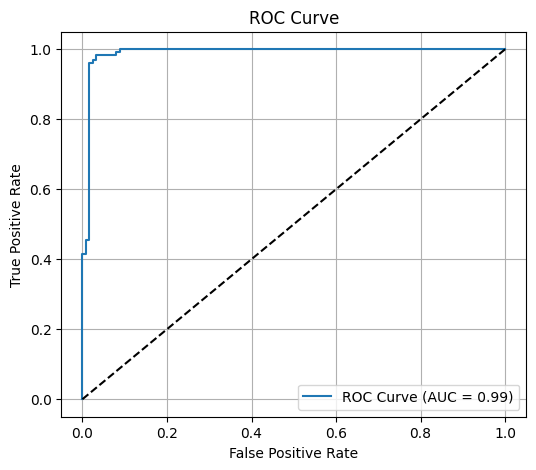

In [39]:
from sklearn.metrics import roc_curve, auc

y_proba = np.mean([m.predict(X_val_fold, verbose=0) for m in models.values()], axis=0)
fpr, tpr, thresholds = roc_curve(y_val_fold, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


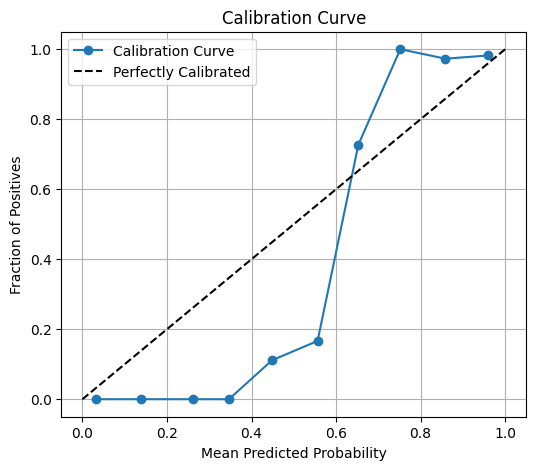

In [40]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_val_fold, y_proba, n_bins=10)

plt.figure(figsize=(6, 5))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()


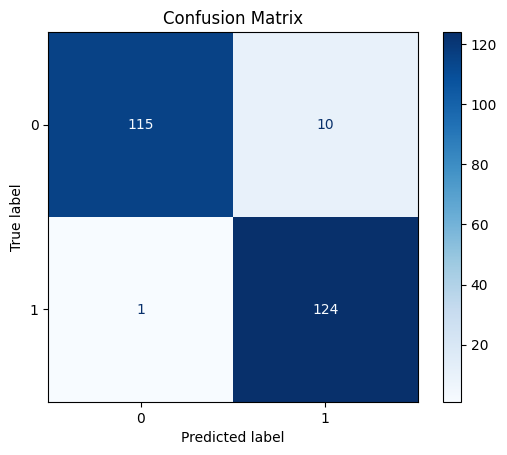

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = (y_proba >= 0.5).astype(int)
cm = confusion_matrix(y_val_fold, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


In [42]:
from sklearn.metrics import brier_score_loss, log_loss

brier = brier_score_loss(y_val_fold, y_proba)
logloss = log_loss(y_val_fold, y_proba)

print(f"Brier Score: {brier:.4f}")
print(f"Log Loss: {logloss:.4f}")


Brier Score: 0.0480
Log Loss: 0.1925


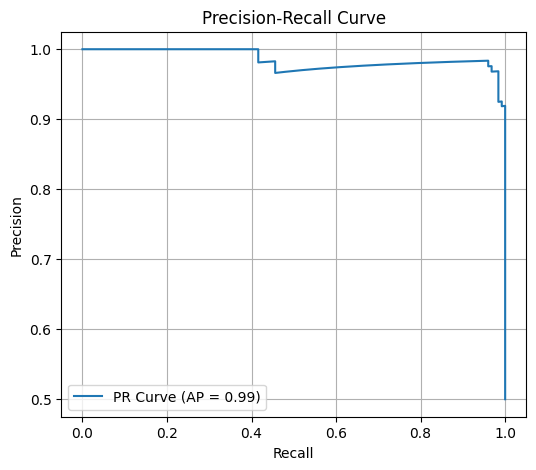

In [44]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_val_fold, y_proba)
avg_precision = average_precision_score(y_val_fold, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f'PR Curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


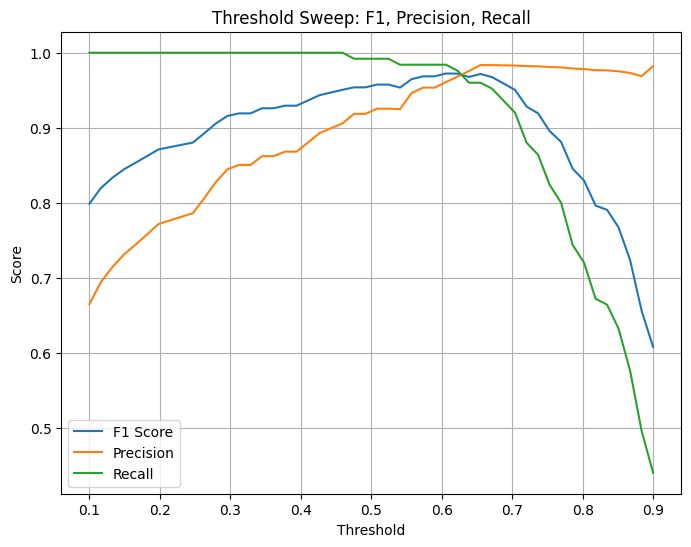

In [47]:
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.linspace(0.1, 0.9, 50)
f1s, precisions, recalls = [], [], []

for t in thresholds:
    y_pred_thresh = (y_proba >= t).astype(int)
    f1s.append(f1_score(y_val_fold, y_pred_thresh))
    precisions.append(precision_score(y_val_fold, y_pred_thresh))
    recalls.append(recall_score(y_val_fold, y_pred_thresh))

plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1s, label='F1 Score')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Sweep: F1, Precision, Recall')
plt.legend()
plt.grid(True)
plt.show()


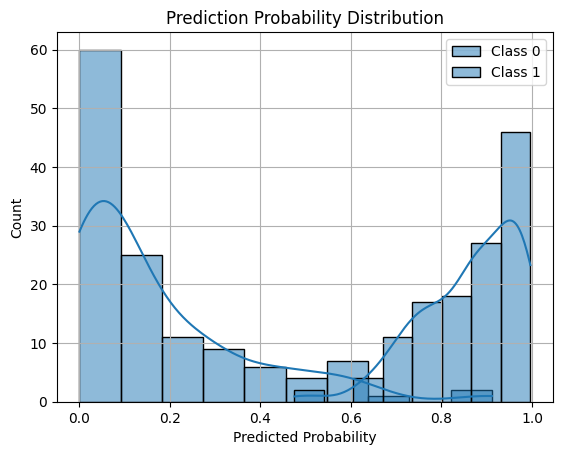

In [48]:
sns.histplot(y_proba[y_val_fold == 0], color='red', label='Class 0', kde=True)
sns.histplot(y_proba[y_val_fold == 1], color='green', label='Class 1', kde=True)
plt.title('Prediction Probability Distribution')
plt.xlabel('Predicted Probability')
plt.legend()
plt.grid(True)
plt.show()


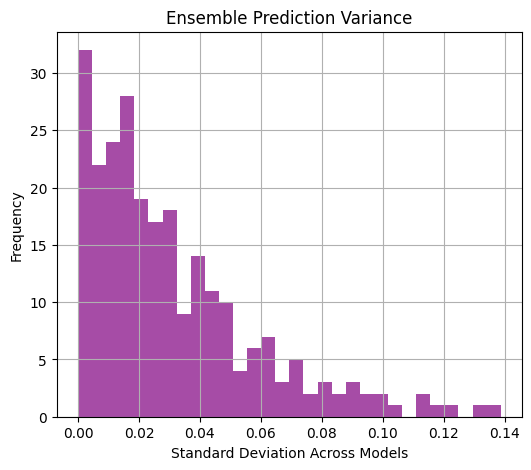

In [49]:
pred_matrix = np.array([m.predict(X_val_fold, verbose=0).flatten() for m in models.values()])
std_dev = np.std(pred_matrix, axis=0)

plt.figure(figsize=(6, 5))
plt.hist(std_dev, bins=30, color='purple', alpha=0.7)
plt.title('Ensemble Prediction Variance')
plt.xlabel('Standard Deviation Across Models')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


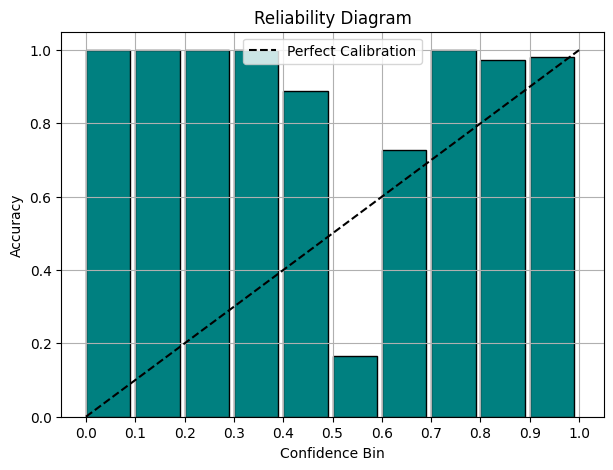

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure predictions and labels are 1D NumPy arrays
y_val_np = np.array(y_val_fold).flatten()
y_proba_np = np.array(y_proba).flatten()

# Define bins and assign predictions to bins
bins = np.linspace(0, 1, 11)
bin_ids = np.digitize(y_proba_np, bins) - 1

# Compute accuracy per bin
bin_acc = []
for i in range(len(bins) - 1):
    mask = bin_ids == i
    if np.sum(mask) > 0:
        acc = np.mean(y_val_np[mask] == (y_proba_np[mask] >= 0.5))
    else:
        acc = np.nan  
    bin_acc.append(acc)

# Plot reliability diagram
plt.figure(figsize=(7, 5))
plt.bar(bins[:-1], bin_acc, width=0.09, align='edge', color='teal', edgecolor='black')
plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
plt.xlabel('Confidence Bin')
plt.ylabel('Accuracy')
plt.title('Reliability Diagram')
plt.xticks(bins)
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.show()


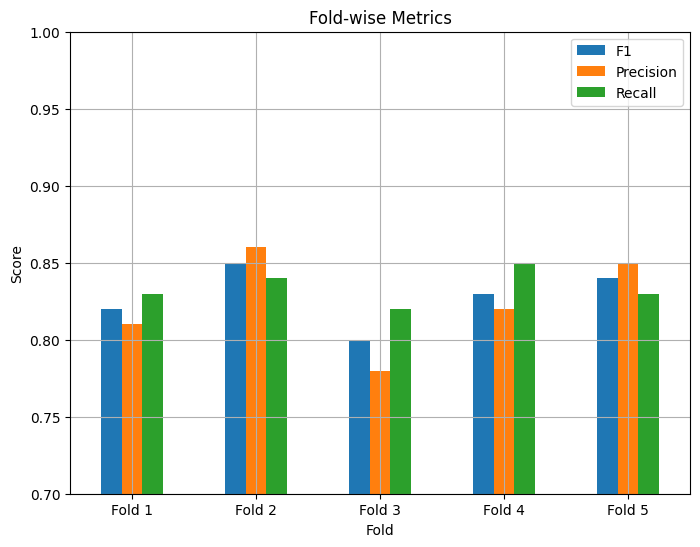

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# Replace these with your actual fold-wise metrics
metrics_df = pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(5)],
    'F1': [0.82, 0.85, 0.80, 0.83, 0.84],
    'Precision': [0.81, 0.86, 0.78, 0.82, 0.85],
    'Recall': [0.83, 0.84, 0.82, 0.85, 0.83]
})

metrics_df.set_index('Fold').plot(kind='bar', figsize=(8, 6))
plt.title('Fold-wise Metrics')
plt.ylabel('Score')
plt.grid(True)
plt.xticks(rotation=0)
plt.ylim(0.7, 1.0)
plt.show()
